# Notebook to try to estimate the "offer success" for a customer. That is, the probability that a customer views and completes an offer in its active time, in that order.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier

ROOT = '../..'
DATA = os.path.join(ROOT, 'data')
DATA_RAW = os.path.join(DATA, 'raw')
SRC = os.path.join(ROOT, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_pickle(os.path.join(DATA, 'interim', 'static_data.pkl'))
data = pp.anonimize_data(data)

In [3]:
data.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 25 columns):
time                     76277 non-null int64
age                      66501 non-null float64
gender                   66501 non-null object
income                   66501 non-null float64
missing_demographics     76277 non-null int64
member_epoch_days        76277 non-null int64
difficulty               76277 non-null float64
duration                 76277 non-null float64
offer_type               76277 non-null object
reward_t                 76277 non-null float64
channel_social           76277 non-null float64
channel_email            76277 non-null float64
channel_web              76277 non-null float64
channel_mobile           76277 non-null float64
completed                76277 non-null int64
expected_finish          76277 non-null float64
finish                   76277 non-null float64
success                  76277 non-null int64
view_time                57227 non-null

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [6]:
class BasicEncoder(BaseEstimator, TransformerMixin):
    """ Transforms the Basic dataset. """
    
    def __init__(self):
        super(BaseEstimator, self).__init__()
        self.offer_type_encoder = LabelEncoder()
        
    def fit(self, X, y=None):
        self.offer_type_encoder.fit(X['offer_type'])
        return self
        
    def transform(self, X):
        res = X.copy()
        res['offer_type'] = self.offer_type_encoder.transform(X['offer_type'])
        return res

In [7]:
encoder = BasicEncoder()
X = encoder.fit_transform(data)
X.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,M,72000.0,0,17277,0.0,3.0,2,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,M,72000.0,0,17277,0.0,4.0,2,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,M,72000.0,0,17277,5.0,5.0,0,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,M,72000.0,0,17277,10.0,10.0,1,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,M,72000.0,0,17277,10.0,7.0,1,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [8]:
data.loc[data.offer_type == 'informational', 'success'] = data.loc[
    data.offer_type == 'informational', 'viewed']

In [9]:
data.head()

,time,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,168,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,...,240.0,240.0,1,192.0,1,0.0,22.16,22.16,22.16,22.16
1,336,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,...,432.0,432.0,1,372.0,1,0.0,8.57,8.57,8.57,8.57
2,408,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,504,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,576,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [10]:
def get_success_data(
    basic_dataset_path=os.path.join(DATA, 
                                    'interim',
                                    'static_data.pkl'),
    time_limit = 450,
    informational_success=True
):
    """ 
    Generates the dataset to predict whether an offer was successful.
    An offer is considered successful if it is viewed and then completed. In
    the case of informational offers a visualization alone may be considered a
    success or not.
    Args:
        basic_dataset_path(str): The path to the pickle containing the basic
            dataset
        time_limit(int): The limit to split the train and test sets.
        informational_success(boolean): Whether a visualization of an 
            informational offer should be considered as a success.
    
    Returns:
        X_train(pd.DataFrame): The training dataset.
        X_test(pd.DataFrame): The test dataset.
        y_train(pd.Series): The training target.
        y_test(pd.Series): The test target.
        BasicEncoder: An encoder to use in a ML pipeline.
    """
    
    data = pd.read_pickle(basic_dataset_path)
    data = pp.anonimize_data(data)
    if informational_success:
        data.loc[data.offer_type == 'informational', 'success'] = data.loc[
            data.offer_type == 'informational', 'viewed']
    
    X_train = data[data.time < time_limit].drop(pp.FUTURE_INFO, axis=1)
    y_train = data.loc[data.time < time_limit, 'success']
    X_test = data[data.time >= time_limit].drop(pp.FUTURE_INFO, axis=1)
    y_test = data.loc[data.time >= time_limit, 'success']
    
    # Drop the columns that depend on absolute time
    X_train = X_train.drop(['time', 'expected_finish'], axis=1)
    X_test = X_test.drop(['time', 'expected_finish'], axis=1)
    
    encoder = pp.BasicEncoder()
    
    return X_train, X_test, y_train, y_test, encoder

In [11]:
X_train, X_test, y_train, y_test, encoder = get_success_data()

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [14]:
from time import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """ 
    Shows some training and test results. Returns the trained model and the 
    predictions.
    """
    # Fit the model
    tic = time()
    model.fit(X_train, y_train)
    toc = time()
    print('Training time: {} seconds.'.format(toc - tic))
    
    # Predict and show results
    y_train_pred = model.predict(X_train)
    print('-'*44 + 'TRAIN RESULTS' + '-'*44)
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_train_pred))
    print('Classification Report:')
    print(classification_report(y_train, y_train_pred))
    print('-'*100)
    
    y_test_pred = model.predict(X_test)
    print('-'*44 + 'TEST RESULTS' + '-'*44)
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_test_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_test_pred))
    print('-'*100)
    
    print('\n' + '_'*51)
    print('| MAIN METRIC (test f1-score): {} |'.format(
        f1_score(y_test, y_test_pred)))
    print('-'*51)
    
    return model, y_train_pred, y_test_pred

In [16]:
model, y_train_pred, y_test_pred = evaluate_model(model, X_train, X_test, y_train, y_test)

Training time: 69.69393515586853 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[23433  3442]
 [ 3490 20443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     26875
           1       0.86      0.85      0.86     23933

   micro avg       0.86      0.86      0.86     50808
   macro avg       0.86      0.86      0.86     50808
weighted avg       0.86      0.86      0.86     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10080  3908]
 [ 3432  8049]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     13988
           1       0.67      0.70      0.69     11481

   micro avg       

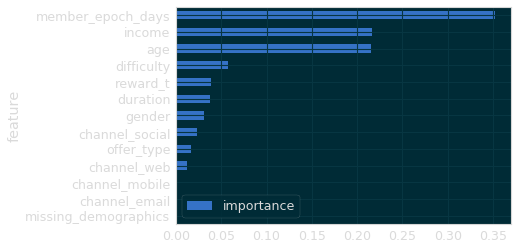

In [17]:
feat_imp = np.vstack([X_train.columns, 
                      model.named_steps['estimator'].feature_importances_]).T
feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'importance'])
feat_imp = feat_imp.sort_values(by='importance').set_index('feature')
feat_imp.plot(kind='barh')

In [18]:
model.named_steps['estimator'].feature_importances_

array([0.21564204, 0.03048578, 0.21616267, 0.        , 0.35201818,
       0.05752961, 0.0379626 , 0.01635646, 0.03833861, 0.02319696,
       0.        , 0.01230711, 0.        ], dtype=float32)

In [19]:
from xgboost import plot_importance

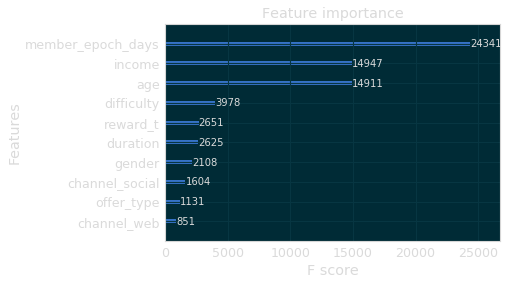

In [20]:
plot_importance(model.named_steps['estimator'])

In [21]:
def show_feat_importances(model, X_train):
    """ 
    Show a barplot with the feature importances for this model's estimator.
    The model is assumed to be a pipeline and the estimator name within the
    pipeline is 'estimator'.
    """
    feat_imp = np.vstack([X_train.columns, 
                      model.named_steps['estimator'].feature_importances_]).T
    feat_imp = pd.DataFrame(feat_imp, columns=['feature', 'importance'])
    feat_imp = feat_imp.sort_values(by='importance').set_index('feature')
    feat_imp.plot(kind='barh')
    plt.title('Feature Importances')
    
    # Use built-in importance plot
    plt.figure()
    plot_importance(model.named_steps['estimator'])

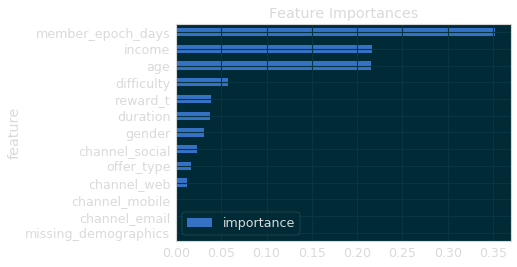

<Figure size 432x288 with 0 Axes>

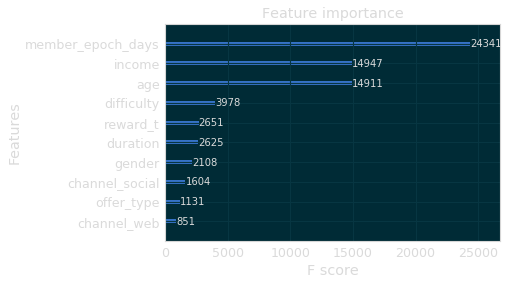

In [22]:
show_feat_importances(model, X_train)

In [23]:
data.time.value_counts().sort_index()

0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: time, dtype: int64

In [24]:
corr_matrix = X_train.join(y_train).corr()

In [25]:
corr_matrix.head()

,age,income,missing_demographics,member_epoch_days,difficulty,duration,reward_t,channel_social,channel_email,channel_web,channel_mobile,success
age,1.000000,0.304423,NaN,-0.008500,-0.002747,0.000603,-0.008122,-0.002502,NaN,0.002282,-0.003256,0.054490
income,0.304423,1.000000,NaN,-0.023294,-0.001536,-0.003432,0.005952,0.007484,NaN,-0.003723,0.003666,0.107092
missing_demographics,NaN,NaN,1.000000,0.032606,-0.003283,-0.005949,0.005974,0.002534,NaN,0.000054,0.006776,-0.169441
member_epoch_days,-0.008500,-0.023294,0.032606,1.000000,-0.000953,-0.001655,-0.002358,0.003023,NaN,0.001396,-0.000407,-0.142892
difficulty,-0.002747,-0.001536,-0.003283,-0.000953,1.000000,0.809765,0.465517,-0.156853,NaN,0.243284,-0.742397,-0.200868


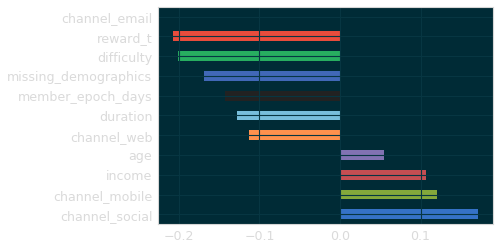

In [26]:
corr_matrix['success'].sort_values(
    ascending=False).drop('success', axis=0).plot(kind='barh')

## Let's decide a strategy to validate the results, independently of the time test-split.

We could use a time division for validation or a random KFold validation. Let's compare them.

### Time split validation.

In [27]:
import src.evaluation.offer_success as evos

In [28]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [29]:
def time_split_validation(model, val_time=370, **kwargs):
    """
    Shows some training and test results, for a time-split validation scheme. 
    Returns the trained model and the predictions.
    Args:
        model(sklearn.BaseEstimator): The model to fit and make predictions.
        val_time(int): The time to make the validation split.
        kwargs(dict): Arguments to be passed to inner functions.

    Returns:
        model(sklearn.BaseEstimator): The trained model.
        y_train_pred(array-like): The predictions for the training set.
        y_test_pred(array-like): The predictions for the test set.
    """
    X_train, X_val, X_test, X_train_val, y_train, y_val, y_test, \
           y_train_val = evos.get_time_split_val(val_time, **kwargs)
    return evos.evaluate_model(model, X_train, X_val, y_train, y_val)

In [30]:
time_split_validation(model)

Training time: 42.91053915023804 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[17920  2212]
 [ 2165 15733]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     20132
           1       0.88      0.88      0.88     17898

   micro avg       0.88      0.88      0.88     38030
   macro avg       0.88      0.88      0.88     38030
weighted avg       0.88      0.88      0.88     38030

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[4943 1800]
 [1963 4072]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      6743
           1       0.69      0.67      0.68      6035

   micro avg       0.71

(Pipeline(memory=None,
      steps=[('encoder', BasicEncoder()), ('estimator', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1,
        feature_names=Index(['age', 'gender', 'income', 'missing_demographics', 'member_epoch_days',
        'difficulty', 'duration', 'offer_type', 'reward...
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1))]),
 array([1, 1, 0, ..., 1, 0, 1]),
 array([1, 1, 1, ..., 0, 1, 1]))

### Random KFold validation

In [31]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [32]:
def random_kfold_validation(model, n_splits=3):
    """
    Shows some training and validation results, for a random kfold validation 
    scheme.
    Args:
        model(sklearn.BaseEstimator): The model to fit and make predictions.
        n_splits(int): The number of folds for the cross-validation.
    """
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2018)
    X_train_val, X_test, y_train_val, y_test, \
        encoder = sd.get_success_data(drop_time=True)
    
    # Train and validate for each fold
    f1_train = list()
    f1_val = list()
    i = 0
    for train_index, test_index in skf.split(X_train_val, y_train_val):
        i += 1
        print('Fold - {}'.format(i))
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
        model, y_train_pred, y_val_pred = evos.evaluate_model(
            model, X_train, X_val, y_train, y_val)
        f1_train.append(f1_score(y_train, y_train_pred))
        f1_val.append(f1_score(y_val, y_val_pred))
    
    # Show results
    print('Training F1-score: {} +- {}'.format(np.mean(f1_train), np.std(f1_train)))
    print()
    print('Validation F1-score: {} +- {}'.format(np.mean(f1_val), 2*np.std(f1_val)))

In [33]:
random_kfold_validation(model)

Fold - 1
Training time: 36.27270197868347 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16131  1785]
 [ 1815 14140]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17916
           1       0.89      0.89      0.89     15955

   micro avg       0.89      0.89      0.89     33871
   macro avg       0.89      0.89      0.89     33871
weighted avg       0.89      0.89      0.89     33871

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[6495 2464]
 [2494 5484]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8959
           1       0.69      0.69      0.69      7978

   micro avg  

### Random train-val-test-split validation

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
def random_1fold_validation(model):
    """
    Shows some training and validation results, for a random train-val-test 
    validation scheme.
    Args:
        model(sklearn.BaseEstimator): The model to fit and make predictions.
    """
    X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
        drop_time=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                      y_train_val, 
                                                      test_size=0.3, 
                                                      random_state=2018)
    model, y_train_pred, y_val_pred = evos.evaluate_model(model, X_train, X_val, 
                                                        y_train, y_val)
    print('Training F1-score: {}'.format(f1_score(y_train, y_train_pred)))
    print()
    print('Validation F1-score: {}'.format(f1_score(y_val, y_val_pred)))

In [36]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [37]:
random_1fold_validation(model)

Training time: 58.457170724868774 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16849  1940]
 [ 1910 14866]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     18789
           1       0.88      0.89      0.89     16776

   micro avg       0.89      0.89      0.89     35565
   macro avg       0.89      0.89      0.89     35565
weighted avg       0.89      0.89      0.89     35565

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5860 2226]
 [2230 4927]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8086
           1       0.69      0.69      0.69      7157

   micro avg       0.7

### Random 1-Fold split in customers

In [38]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [39]:
def random_1fold_cust_validation(model):
    """
    Shows some training and validation results, for a random train-val-test 
    validation scheme. The dataset is divided by customers.
    Args:
        model(sklearn.BaseEstimator): The model to fit and make predictions.
    """
    X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
        drop_time=True, anon=False)

    # Get random customer splits
    val_size = 0.3
    customers = X_train_val.person.unique()
    n_train = int(np.floor(customers.shape[0] * (1.0 - val_size)))
    np.random.shuffle(customers)
    X_train = X_train_val[X_train_val.person.isin(customers[:n_train])]
    X_val = X_train_val[X_train_val.person.isin(customers[n_train:])]
    y_train = y_train_val[X_train_val.person.isin(customers[:n_train])]
    y_val = y_train_val[X_train_val.person.isin(customers[n_train:])]
    
    # Anonimize
    X_train = pp.anonimize_data(X_train)
    X_val = pp.anonimize_data(X_val)
    
    # Evaluate and show results
    model, y_train_pred, y_val_pred = evos.evaluate_model(
        model, X_train, X_val, y_train, y_val)
    print('Training F1-score: {}'.format(f1_score(y_train, y_train_pred)))
    print()
    print('Validation F1-score: {}'.format(f1_score(y_val, y_val_pred)))

In [40]:
random_1fold_cust_validation(model)

Training time: 56.02696084976196 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16792  2027]
 [ 1961 14788]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     18819
           1       0.88      0.88      0.88     16749

   micro avg       0.89      0.89      0.89     35568
   macro avg       0.89      0.89      0.89     35568
weighted avg       0.89      0.89      0.89     35568

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5753 2303]
 [2368 4816]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      8056
           1       0.68      0.67      0.67      7184

   micro avg       0.69

### Test results

In [41]:
model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

In [42]:
def offer_success_test(model):
    """
    Shows some training and test results, for a time-split validation scheme.
    Args:
        model(sklearn.BaseEstimator): The model to fit and make predictions.
    """
    X_train, X_test, y_train, y_test, encoder = sd.get_success_data()
    model, y_train_pred, y_test_pred = evos.evaluate_model(
        model, X_train, X_test, y_train, y_test)
    print('Training F1-score: {}'.format(f1_score(y_train, y_train_pred)))
    print()
    print('Test F1-score: {}'.format(f1_score(y_test, y_test_pred)))

In [43]:
offer_success_test(model)

Training time: 97.76098990440369 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[23433  3442]
 [ 3490 20443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     26875
           1       0.86      0.85      0.86     23933

   micro avg       0.86      0.86      0.86     50808
   macro avg       0.86      0.86      0.86     50808
weighted avg       0.86      0.86      0.86     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10080  3908]
 [ 3432  8049]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     13988
           1       0.67      0.70      0.69     11481

   micro avg       

### Conclusion: All the validation methods give similar results to the test evaluation. The "hardest" validation seems to be the one that uses only previously unseen customers to validate. KFold validation takes the longest time, as usual. The time-split validation is the most similar to the way the test validation is made, and also seems to be the closest to the real scenario. It is also fast, so I will use that method for validation. Anyway, if possible and reasonable, I will report the "unseen customers" metrics, because I think they are informative.


### The fact that the "Random" validations yield similar results to the "time-split" validation could be seen as an informal indicator of stationarity (at least in the one-month period).